## Import modules

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

from scipy import stats
from torchvision import transforms
from torch.utils.data import DataLoader

sys.path.append('d:/gsn-projekt')

import amphibian.preprocess.preprocessing as preproc
from amphibian.fetch.reader import AmphibianReader
from amphibian.preprocess.train_test_split import TrainTestSplit
from amphibian.architectures import RNNModel, AttentionModel
from amphibian.train import SingleTrainer, batch_size_dist, CrossValidation

## Parameters

In [17]:
WINDOW_WIDTH = 13
PARAM_GRID_RNN = {
    'batch_size': batch_size_dist(32, 256),
    'seq_len': stats.randint(10, 11),
    'input_size': stats.randint(126, 127),
    'hidden_size': stats.randint(5, 20),
    'n_outputs': stats.randint(3,4),
    'num_layers': stats.randint(3,4),
    'dropout': stats.uniform(0.5, 0.3)
}

In [3]:
for k,v in PARAM_GRID_RNN.items():
    print(k, v.rvs(size=1)[0])

batch_size 64
seq_len 10
input_size 126
hidden_size 16
n_outputs 3
num_layers 3
dropout 0.5313982760602641


## Read data

In [15]:
import os
os.listdir(r'D:\gsn-projekt\data\all_values\stocks\try_all\ASIA_PACIFIC')

['ASHOKLEY.NS',
 'ATULAUTO.NS',
 'C07.SI',
 'EICHERMOT.NS',
 'HEROMOTOCO.NS',
 'HINDMOTORS.NS',
 'M&M.NS',
 'MARUTI.NS',
 'SMLISUZU.NS',
 'TATAMOTORS.NS',
 'TATAMTRDVR.NS',
 'TVSMOTOR.NS']

In [2]:
DATA_PATH = r'D:\gsn-projekt\data\all_values\stocks\try_all'

ar = AmphibianReader(DATA_PATH, datetime.datetime(2011, 1, 1), datetime.datetime(2018, 1, 1))

_ = ar.create_torch()

## Train test split

In [18]:
tts = TrainTestSplit(ar, int_start=0, int_end=1000)

In [19]:
tsds = preproc.TimeSeriesDataset(tts, int_len=WINDOW_WIDTH, transform=transforms.Compose([
    preproc.FillNaN(), preproc.Normalizing(), preproc.DummyFillNaN(), preproc.Formatting(), 
    preproc.FormattingY()
]))

In [20]:
tsds.whole_set['train_y'].size(1)

10

## Batch check

In [21]:
sampled_params = {}
for k, v in PARAM_GRID_RNN.items():
    s = v.rvs(size=1)[0]
    if s.dtype == float:
        sampled_params[k] = float(s)
    else:
        sampled_params[k] = int(s)

In [22]:
dl = DataLoader(tsds, batch_size=256, shuffle=True)

In [24]:
for i, batch in enumerate(dl):
    print(batch['train_obs'].view(-1, 13 * 60).size())

torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([256, 780])
torch.Size([200, 780])


In [13]:
vds = preproc.ValidDataset(tsds)

In [14]:
len(vds)

18145

In [15]:
vds[18144]

{'test_obs': tensor([[ 0.2257, -0.6336,  1.7779,  ...,  3.7820,  5.2672, 20.6378],
         [ 0.1976, -0.6810,  1.7514,  ...,  3.8892,  5.3069, 22.2276],
         [ 0.3100, -0.6810,  1.7514,  ...,  4.1682,  5.4980, 21.6737],
         ...,
         [ 0.2679, -0.6336,  1.6189,  ...,  4.2793,  5.6861, 21.5814],
         [ 0.2257, -0.5863,  1.7514,  ...,  4.2911,  5.6420, 21.8737],
         [ 0.3522, -0.5863,  1.7514,  ...,  4.4313,  5.8640, 22.0891]],
        device='cuda:0'), 'test_y': tensor(2, device='cuda:0')}

In [16]:
vds[1]['test_obs'].shape

torch.Size([10, 126])

## Logreg

In [4]:
SAMPLING_GRID = {
    'learning_rate': stats.uniform(1e-4, 1e-2),
    'batch_size': batch_size_dist(32, 256),
    'seq_len': stats.randint(5, 30)
}

CONSTANT_GRID = {
    'input_size': 60,
    'n_outputs': 3,
    'max_epochs': 3,
    'early_stopping_patience': 10
}

In [5]:
cv = CrossValidation(ar, 0, 1000, 'SoftmaxRegressionModel', SAMPLING_GRID, CONSTANT_GRID, 'd:/gsn-projekt/data')

In [6]:
cv.run()

STARTED CROSS-VALIDATION
Optimizing hyperparameters for SoftmaxRegressionModel
Beginning CV iteration 1
Trying for the following parameters: {'learning_rate': 0.0067402035137132015, 'batch_size': 128, 'seq_len': 27}
	Fold: 1
Starting epoch 1


d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view(). at ..\aten\src\THC/generic/THCTensor.cpp:209

## Testing CV

In [3]:
SAMPLING_GRID = {
    'learning_rate': stats.uniform(1e-4, 1e-2),
    'batch_size': batch_size_dist(32, 256),
    'seq_len': stats.randint(5, 30),
    'hidden_size': stats.randint(5, 20),
    'dropout': stats.uniform(0, 0.5)
}

CONSTANT_GRID = {
    'input_size': 60,
    'n_outputs': 3,
    'num_layers': 2,
    'max_epochs': 5,
    'early_stopping_patience': 10
}

In [4]:
cv = CrossValidation(ar, 0, 1000, 'AttentionModel', SAMPLING_GRID, CONSTANT_GRID, 'd:/gsn-projekt/data')

In [5]:
cv.run()

STARTED CROSS-VALIDATION
Optimizing hyperparameters for AttentionModel
Beginning CV iteration 1
Trying for the following parameters: {'learning_rate': 0.00326378313249938, 'batch_size': 128, 'seq_len': 8, 'hidden_size': 18, 'dropout': 0.4307389317120314}
	Fold: 1


d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
d:\gsn-projekt\venv\lib\site-packages\numpy\lib\nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Starting epoch 1
Loss: 0.9783417828705
Starting epoch 2
Loss: 1.0149185333562933
Starting epoch 3
Loss: 0.9779268632764402
Starting epoch 4
Loss: 0.9799271459164827
Starting epoch 5
Loss: 0.9916981925135073
	Fitting ended after 5 epochs
	Loss on this fold: 0.99170
	Fold: 2
Starting epoch 1


d:\gsn-projekt\venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Loss: 0.8560307401677837
Starting epoch 2
Loss: 0.8363052891648334
Starting epoch 3


KeyboardInterrupt: 

## Single training

In [43]:
print(sampled_params)

{'batch_size': 128, 'seq_len': 10, 'input_size': 126, 'hidden_size': 13, 'n_outputs': 3, 'num_layers': 3, 'dropout': 0.7396891804268992}


In [46]:
rnnmodel = RNNModel(**sampled_params)
st = SingleTrainer(rnnmodel, batch_size=sampled_params['batch_size'], early_stopping_patience=20, learning_rate=1e-3)

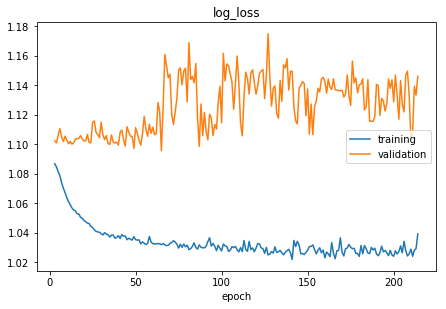

log_loss:
training   (min:    1.022, max:    1.094, cur:    1.039)
validation (min:    1.096, max:    1.175, cur:    1.146)


KeyboardInterrupt: 

In [47]:
st.train(tsds, vds, verbose=False)

## Single training Attention

In [34]:
sampled_params_attn = sampled_params
sampled_params_attn['recurrent_type'] = 'lstm'
sampled_params_attn['alignment'] = 'ffnn'

In [39]:
attnmodel = AttentionModel(**sampled_params)
st_attn = SingleTrainer(attnmodel, batch_size = sampled_params['batch_size'], learning_rate=1e-3)

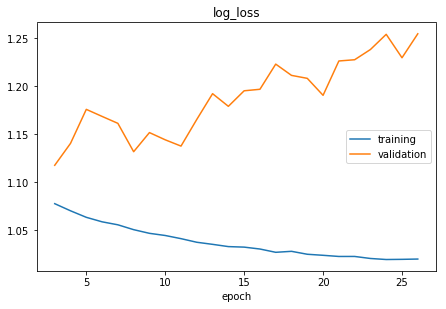

log_loss:
training   (min:    1.019, max:    1.088, cur:    1.020)
validation (min:    1.098, max:    1.254, cur:    1.254)


KeyboardInterrupt: 

In [40]:
st_attn.train(tsds, vds, verbose=False)